In [62]:
# Importamos librerías

import numpy as np
import pandas as pd

# Abrimos fichero
# Introducir en path_file la ruta donde hemos descargado el fichero

path_file = "XXXXX"
df = pd.read_csv(path_file, sep = ';')

#Visualizamos primeras filas y nombres de variables

df.head(5)
df.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
       'Beds', 'Bed Type', 'Amenities', 'Square Feet', 'Price', 'Weekly Price',
       'Month

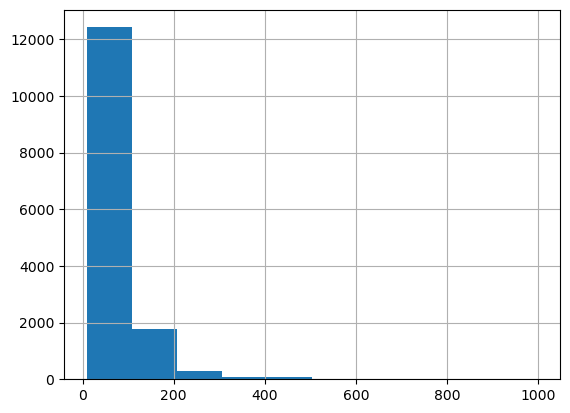

In [63]:
# Visualizamos distribución de la variable objetivo ("Price") para eliminar posibles outliers

df["Price"].hist()

# Tras observar el histograma y contear el número de casos por encima de 600, decidimos señalar y eliminar como outliers todos los valores de "Price" por encima de 600

(df["Price"] > 600).sum()
df = df[df["Price"] <= 600]

In [64]:
# Obtenemos los percentiles 33.33 y 66.66 de la distribución de "Price" para establecer los cortes que determinarán las categorías a predecir de nuestra nueva variable objetivo ("price_range")

price_range = []

for price in df["Price"]:
    if price <= df["Price"].quantile(0.3333):
        price_range.append(1)
    elif price <= df["Price"].quantile(0.6666):
        price_range.append(2) 
    else:
        price_range.append(3)

df["price_range"] = pd.Series(price_range, index = df.index)

In [65]:
# Importamos librerías

from sklearn.model_selection import train_test_split

# Reseteamos índices para conservar en las particiones los índices del df previo al split

df.reset_index(drop=True, inplace=True)

# Dividimos en train y test

train_x, test_x, train_y, test_y = train_test_split(df.iloc[:,:-1], df.iloc[:,-1],
                                                      test_size=0.25,
                                                      random_state=17,
                                                      shuffle=True,
                                                      stratify=df.iloc[:,-1])

In [66]:
# Arrancamos el preprocesado de datos
# Empezamos eligiendo las variables a utilizar. Visualizo la totalidad de variables, cambiando el display por defecto para poder visualizar todas las columnas y su (tipo de) contenido

pd.set_option('display.max_columns', None)
train_x.head(15)

# La selección de variables es, en este sentido, manual. Como criterio se han escogido variables numéricas y categóricas que tengan potencial aporte en un modelo de clasifiación. Se han excluido de esta selección las variables que por su naturaleza (id's, url´s, campos de texto abiertos de carácter descriptivo/comentarios, variables repetidas o redundantes) no son útilies para resolver un problema de clasificación

train_x_vars = ['Zipcode', 'Market', 'Country Code', 'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Square Feet', 'Guests Included', 'Minimum Nights', 'Maximum Nights', 'Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Location', 'Review Scores Value', 'Cancellation Policy', 'Calculated host listings count']

train_x = train_x[train_x_vars]

In [67]:
# Visualizamos NA's y valores únicos para seguir con la selección de variables y el preprocesado

train_x.isnull().sum()
train_x.nunique()

Zipcode                           523
Market                             39
Country Code                       18
Property Type                      21
Room Type                           3
Accommodates                       16
Bathrooms                          16
Bedrooms                           10
Beds                               16
Bed Type                            5
Square Feet                        91
Guests Included                    15
Minimum Nights                     39
Maximum Nights                    148
Number of Reviews                 252
Review Scores Rating               52
Review Scores Accuracy              9
Review Scores Cleanliness           9
Review Scores Checkin               9
Review Scores Communication         8
Review Scores Location              8
Review Scores Value                 9
Cancellation Policy                 8
Calculated host listings count     45
dtype: int64

In [68]:
# Tras visualizar decidimos eliminar la variable "Square Feet" por tener casi la totalidad de valores en NaN

train_x = train_x.drop("Square Feet", axis = 1)

# Para el resto de variables, en el caso de las categóricas imputamos "Others" y en el caso de las numéricas imputamos a sus respectivas medias
# Guardo, antes de imputar NA's, una copia de train_x que utilizaré posteriormente

train_x_formeanimputation = train_x

for var in train_x.columns:
    if train_x[var].dtypes == object:
        train_x[var] = train_x[var].fillna("Others")
    else:
        train_x[var] = train_x[var].fillna(train_x[var].mean())

# Además, con objeto simplificar el modelo y trabajar con datos que nos resulten más cercanos, filtramos el dataframe para quedarnos sólo con casos de España

train_x = train_x[train_x['Country Code'] == 'ES']

In [69]:
# Covertimos ahora todas las variables categóricas a one-hot para poder procesarlas numéricamente

categorical_vars = list(var for var in train_x if train_x[var].dtypes == object)
numerical_vars = list(var for var in train_x if train_x[var].dtypes != object) 
train_x = pd.get_dummies(train_x, columns = categorical_vars)

# Añadimos una categoría "_Others" a cada una de las variables categóricas. Como veremos más abajo servirá para garantizar presencia de las mismas variables en train y test, asimilando ambos conjuntos

for var in categorical_vars:
    train_x[var+"_Others"] = 0

In [70]:
# Hacemos todas las transformaciones de train_x en el dataframe de test_x

# Seleccionamos las variables que vamos a usar

test_x = test_x[train_x_vars]

# Eliminamos la variable "Square Feet"

test_x = test_x.drop("Square Feet", axis = 1)

# Procesamos los NA's de las variables categóricas y numéricas (imputando a las medias de train)

for var in test_x.columns:
    if test_x[var].dtypes == object:
        test_x[var] = test_x[var].fillna("Others")
    else:
        test_x[var] = test_x[var].fillna(train_x_formeanimputation[var].mean())

# Filtramos el dataframe para quedarnos sólo con casos de España

test_x = test_x[test_x['Country Code'] == 'ES']

# Convertimos las variables categóricas a one-hot

test_x = pd.get_dummies(test_x, columns = categorical_vars)

In [71]:
# Apoyándonos en las categorías "var+_Others" (añadidas más arriba) creamos, eliminamos y transformamos variables para asimilar los conjuntos de train y test

vars_no_incommon_train = [var for var in train_x.columns if var not in test_x.columns]
vars_no_incommon_test = [var for var in test_x.columns if var not in train_x.columns]

for var in vars_no_incommon_train:
    test_x[var] = 0
for var in vars_no_incommon_test:
    test_x.drop(var, axis = 1, inplace = True)
    test_x[var+"_Others"] = 1

train_x_columnssorted = sorted(train_x.columns)
train_x = train_x[train_x_columnssorted]
test_x = test_x[train_x_columnssorted]

C:\Users\Victor\AppData\Local\Temp\ipykernel_10120\4253091624.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_x[var+"_Others"] = 1
C:\Users\Victor\AppData\Local\Temp\ipykernel_10120\4253091624.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_x[var+"_Others"] = 1
C:\Users\Victor\AppData\Local\Temp\ipykernel_10120\4253091624.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

In [72]:
# Ya hemos finalizado con el dropeo de variables y casos, así que filtramos train_y y test_y para los casos seleccionados (no eliminados durante el preprocesamiento) en train_x y test_x

train_y = train_y.loc[train_x.index]                     
test_y = test_y.loc[test_x.index]

In [73]:
# Normalizamos las variables, sólo las originalmente numéricas (no one-hot)
# Subdividimos train_x entre variables a normalizar y las que no normalizaremos

train_x_tonorm = train_x[numerical_vars]
train_x_notnorm = train_x.drop(numerical_vars, axis = 1)

# Después normalizamos

from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler().fit(train_x_tonorm)
train_x_normalized = scaler_X.transform(train_x_tonorm)

# Por último volvemos a unir el train_x con las variables normalizadas y las no-normalizadas

train_x_notnorm = train_x_notnorm.values
train_x = np.concatenate([train_x_normalized, train_x_notnorm], axis = 1)

In [74]:
# Hacemos lo mismo en test, con la normalización (scaler) de train

test_x_tonorm = test_x[numerical_vars]
test_x_notnorm = test_x.drop(numerical_vars, axis = 1)

test_x_normalized = scaler_X.transform(test_x_tonorm)

test_x_notnorm = test_x_notnorm.values
test_x = np.concatenate([test_x_normalized, test_x_notnorm], axis = 1)

In [75]:
# Importamos librerías

from sklearn.preprocessing import MinMaxScaler 

# Vamos a (re)normalizar todo entre 0 y 1

mm_scaler = MinMaxScaler()

train_x = pd.DataFrame(mm_scaler.fit_transform(train_x))
test_x = pd.DataFrame(mm_scaler.transform(test_x))

# Por último convertimos la variable objetivo ("price_range") a one-hot para poder procesarla en nuestro modelo 

train_y_cls = pd.get_dummies(train_y)                      
test_y_cls = pd.get_dummies(test_y)

In [76]:
# Importamos librerías

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Creamos un modelo de deep learning adecuado para un problema de clasificación

print(f"Input size: {train_x.shape[1]}")

nb_out = train_y_cls.shape[1]

classifier1 = Sequential()
classifier1.add(Dense(64, input_shape=(train_x.shape[1],), activation='relu'))
classifier1.add(Dense(32, activation='relu'))
classifier1.add(Dense(8, activation='relu'))
classifier1.add(Dense(nb_out, activation='softmax'))

classifier1.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

classifier1.summary()

Input size: 248
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                15936     
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 8)                 264       
                                                                 
 dense_15 (Dense)            (None, 3)                 27        
                                                                 
Total params: 18307 (71.51 KB)
Trainable params: 18307 (71.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
# Entrenamos el modelo con epochs y batch_size fijos

EPOCHS = 30
BS = 64

H = classifier1.fit(x = train_x, y = train_y_cls, batch_size=BS, epochs=EPOCHS, 
                     shuffle=True, verbose=2)

Epoch 1/30
164/164 - 1s - loss: 0.8084 - accuracy: 0.6135 - 1s/epoch - 7ms/step
Epoch 2/30
164/164 - 0s - loss: 0.6415 - accuracy: 0.7377 - 397ms/epoch - 2ms/step
Epoch 3/30
164/164 - 0s - loss: 0.6090 - accuracy: 0.7469 - 355ms/epoch - 2ms/step
Epoch 4/30
164/164 - 0s - loss: 0.5914 - accuracy: 0.7566 - 360ms/epoch - 2ms/step
Epoch 5/30
164/164 - 0s - loss: 0.5807 - accuracy: 0.7601 - 365ms/epoch - 2ms/step
Epoch 6/30
164/164 - 0s - loss: 0.5710 - accuracy: 0.7634 - 359ms/epoch - 2ms/step
Epoch 7/30
164/164 - 0s - loss: 0.5641 - accuracy: 0.7633 - 359ms/epoch - 2ms/step
Epoch 8/30
164/164 - 0s - loss: 0.5591 - accuracy: 0.7698 - 360ms/epoch - 2ms/step
Epoch 9/30
164/164 - 0s - loss: 0.5522 - accuracy: 0.7706 - 359ms/epoch - 2ms/step
Epoch 10/30
164/164 - 0s - loss: 0.5513 - accuracy: 0.7713 - 359ms/epoch - 2ms/step
Epoch 11/30
164/164 - 0s - loss: 0.5441 - accuracy: 0.7717 - 364ms/epoch - 2ms/step
Epoch 12/30
164/164 - 0s - loss: 0.5439 - accuracy: 0.7737 - 358ms/epoch - 2ms/step
Epoc

[]

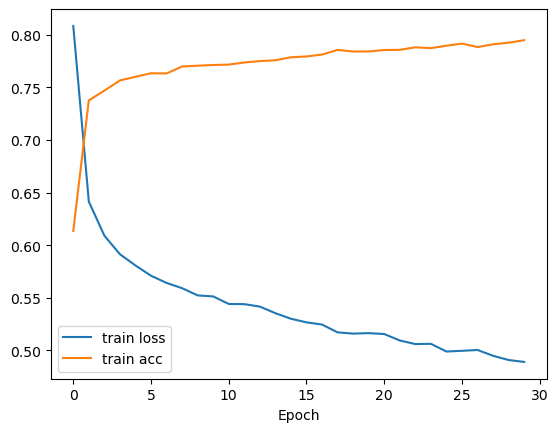

In [78]:
# Importamos librerías

import matplotlib.pyplot as plt

# Visualizamos las curvas de aprendizaje

plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['accuracy'], label='train acc')
plt.legend()
plt.xlabel('Epoch')
plt.plot()

In [79]:
# Damos por bueno el entrenamiento del modelo y, para finalizar, lo evaluamos con el conjunto de test e imprimimos métricas

loss, acc = classifier1.evaluate(test_x, test_y_cls)
print(f'Loss={loss}, Acc={acc}')

110/110 [==============================] - 0s 2ms/step - loss: 0.6448 - accuracy: 0.7481
Loss=0.6448144912719727, Acc=0.7481417655944824


## A modo de conclusiones

Queda demostrado que un modelo sencillo, y computacionalmente ligero, de deep learning consigue alcanzar métricas muy elevadas con un accuracy cercano al 0.75. Parece razonable pensar, aunque no sea objeto de este script, que aumentando epochs y batch size o añadiendo capas dropout al modelo para optimizar su regularización obtendríamos mejores métricas.